In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import random
from collections import defaultdict, Counter
from copy import deepcopy
from pathlib import Path
from datetime import datetime  # For timestamp

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm  # Progress bar
from scipy.stats import shapiro  # Statistical test

# Import necessary modules from brancharchitect
from brancharchitect.io import read_newick
from brancharchitect.leaf_order_distances import (
    circular_distances_trees,
    get_taxa_circular_order,
)

# ------------------------------------------------------------------------------------
# Function Definitions
# ------------------------------------------------------------------------------------


def generate_permutations(
    elements, fixed_positions=None, fixed_elements=None, sample_size=None, seed=None
):
    """
    Generate unique random permutations of the elements list, keeping specified elements fixed.
    Efficiently handles large n without generating all permutations upfront.

    Parameters:
        elements (list): The list of elements to permute.
        fixed_positions (list): Indices of positions to keep fixed.
        fixed_elements (list): Elements to keep fixed (all their occurrences).
        sample_size (int): Number of unique permutations to generate.
        seed (int): Seed for random number generator (for reproducibility).

    Returns:
        list: A list of unique permutations (each permutation is a list).
    """
    if seed is not None:
        random.seed(seed)

    n = len(elements)
    positions = list(range(n))

    # Initialize fixed_positions if not provided
    if fixed_positions is None:
        fixed_positions = []
    else:
        fixed_positions = fixed_positions.copy()

    # Identify positions of elements to fix based on element names
    if fixed_elements:
        fixed_positions.extend(
            [i for i, e in enumerate(elements) if e in fixed_elements]
        )
        # Ensure positions are unique
        fixed_positions = list(set(fixed_positions))

    # Determine positions and elements to permute
    fixed_positions_set = set(fixed_positions)
    permute_positions = [pos for pos in positions if pos not in fixed_positions_set]
    permute_elements = [elements[pos] for pos in permute_positions]

    # Estimate the total number of unique permutations using multinomial coefficient
    from math import factorial

    element_counts = Counter(permute_elements)
    total_unique_permutations = factorial(len(permute_elements))
    for count in element_counts.values():
        total_unique_permutations //= factorial(count)

    if sample_size is None or sample_size > total_unique_permutations:
        sample_size = total_unique_permutations
        print(f"Sample size set to total number of unique permutations: {sample_size}")

    generated_permutations = set()
    attempts = 0
    max_attempts = sample_size * 10  # Avoid infinite loops

    with tqdm(total=sample_size, desc="Generating permutations") as pbar:
        while len(generated_permutations) < sample_size and attempts < max_attempts:
            # Generate a random permutation of the permute elements
            permuted_elements = permute_elements[:]
            random.shuffle(permuted_elements)

            # Reconstruct the full permutation by placing fixed elements back
            temp = elements.copy()
            for idx, pos in enumerate(permute_positions):
                temp[pos] = permuted_elements[idx]

            perm_tuple = tuple(temp)
            if perm_tuple not in generated_permutations:
                generated_permutations.add(perm_tuple)
                pbar.update(1)
            attempts += 1

    if attempts >= max_attempts:
        print(
            f"Reached maximum number of attempts ({max_attempts}). Returning {len(generated_permutations)} unique permutations."
        )

    return [list(perm) for perm in generated_permutations]


def compute_permutation_distances(permutations, tree_list):
    """
    Compute distances for each permutation using the provided list of trees.
    """
    permutation_distances = []
    for permutation in tqdm(permutations, desc="Computing distances"):
        # Reorder trees according to the permutation
        trees_copy = []
        for tree in tree_list:
            new_tree = deepcopy(tree)
            new_tree._initialize_split_indices(permutation)
            new_tree._order = permutation
            new_tree._fix_child_order()
            trees_copy.append(new_tree)
        # Compute the circular distance between the reordered trees
        distance = circular_distances_trees(trees_copy)
        # Store the permutation and its distance
        permutation_distances.append((permutation, distance))
    return permutation_distances


def group_permutations_by_distance(permutation_distances):
    """
    Group permutations based on their calculated distances.
    """
    distance_groups = defaultdict(list)
    for permutation, distance in permutation_distances:
        distance_groups[distance].append(permutation)
    return distance_groups


def calculate_frequencies(permutations, element_list, position_list):
    """
    Calculate the frequency of each element at each position across all permutations.
    """
    counts = np.zeros((len(position_list), len(element_list)))  # positions x elements
    element_index = {elem: idx for idx, elem in enumerate(element_list)}
    for permutation in permutations:
        for pos, elem in enumerate(permutation):
            elem_idx = element_index[elem]
            counts[pos][elem_idx] += 1
    # Convert counts to frequencies
    frequencies = counts / len(permutations)
    # Create a DataFrame for visualization
    df = pd.DataFrame(frequencies, index=position_list, columns=element_list)
    return df


def plot_frequency_heatmap(df, title, pdf_pages, figsize=(8, 6)):
    """
    Plot and save a heatmap of element frequencies at positions.
    """
    plt.figure(figsize=figsize)
    sns.heatmap(
        df,
        fmt=".2f",
        cmap="coolwarm",
        cbar_kws={"label": "Frequency"},
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Element", fontsize=12)
    plt.ylabel("Position", fontsize=12)
    plt.xticks(fontsize=10, rotation=90)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    pdf_pages.savefig()
    plt.close()


def analyze_permutations_by_distance(
    distance_groups, element_list, position_list, pdf_pages, distances_to_analyze
):
    """
    Analyze permutations for specified distances and plot frequency heatmaps.
    """
    for distance in distances_to_analyze:
        permutations = distance_groups[distance]
        df = calculate_frequencies(permutations, element_list, position_list)
        title = f"Element Frequencies at Positions for Distance {distance}"
        plot_frequency_heatmap(df, title, pdf_pages)


def perform_correlation_analysis(
    permutation_distances, element_list, pdf_pages, output_dir
):
    """
    Perform correlation analysis between element positions and distances.
    """
    # Create a DataFrame with positions of elements and their corresponding distances
    data = []
    for permutation, distance in permutation_distances:
        perm_dict = {"Distance": distance}
        for elem in element_list:
            perm_dict[elem] = permutation.index(elem)
        data.append(perm_dict)
    df = pd.DataFrame(data)

    # Compute correlation coefficients
    correlations = df[element_list].corrwith(df["Distance"])

    # Plot correlation coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlations.index, y=correlations.values)
    plt.title(
        "Correlation between Element Positions and Distance",
        fontsize=14,
        pad=15,
    )
    plt.xlabel("Element", fontsize=12)
    plt.ylabel("Correlation Coefficient", fontsize=12)
    plt.xticks(fontsize=10, rotation=90)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    pdf_pages.savefig()
    plt.close()

    # Save correlation coefficients to a CSV file
    correlations.to_csv(os.path.join(output_dir, "correlations.csv"))


def perform_statistical_analysis(permutation_distances, distances, output_dir):
    """
    Perform statistical analysis on the distances and save results.
    """
    # Calculate summary statistics
    stats = {
        "Mean": np.mean(distances),
        "Median": np.median(distances),
        "Standard Deviation": np.std(distances),
        "Variance": np.var(distances),
        "Minimum": np.min(distances),
        "Maximum": np.max(distances),
    }
    stats_df = pd.DataFrame.from_dict(stats, orient="index", columns=["Value"])
    stats_df.to_csv(os.path.join(output_dir, "distance_statistics.csv"))

    # Identify permutations with minimum and maximum distances
    min_distance = stats["Minimum"]
    max_distance = stats["Maximum"]
    min_permutations = [
        perm for perm, dist in permutation_distances if dist == min_distance
    ]
    max_permutations = [
        perm for perm, dist in permutation_distances if dist == max_distance
    ]

    # Save permutations with minimum and maximum distances
    with open(os.path.join(output_dir, "min_permutations.txt"), "w") as f:
        for perm in min_permutations:
            f.write(",".join(perm) + "\n")
    with open(os.path.join(output_dir, "max_permutations.txt"), "w") as f:
        for perm in max_permutations:
            f.write(",".join(perm) + "\n")

    # Perform Shapiro-Wilk normality test
    shapiro_stat, shapiro_p = shapiro(distances)
    shapiro_results = pd.DataFrame(
        {"Test": ["Shapiro-Wilk"], "Statistic": [shapiro_stat], "p-value": [shapiro_p]}
    )
    shapiro_results.to_csv(os.path.join(output_dir, "shapiro_wilk_test.csv"))

    # Print summary of statistical analysis
    print(f"Minimum Distance: {min_distance}")
    print(f"Maximum Distance: {max_distance}")
    print("Summary statistics saved to 'distance_statistics.csv'")
    print("Shapiro-Wilk test results saved to 'shapiro_wilk_test.csv'")

    return min_distance, max_distance, min_permutations, max_permutations


def create_short_report(
    distances,
    permutation_distances,
    element_list,
    position_list,
    min_distance,
    max_distance,
    min_permutations,
    max_permutations,
    distance_groups,
    output_dir,
    experiment_name,
):
    """
    Generate the short PDF report with enhanced plots and statistical analysis.
    """
    short_pdf_path = os.path.join(output_dir, f"{experiment_name}_short_report.pdf")
    with PdfPages(short_pdf_path) as short_pdf:
        # Histogram of Distances
        plt.figure(figsize=(10, 6))
        sns.histplot(distances, bins=50, kde=True, color="skyblue", edgecolor="black")
        plt.title(
            "Distribution of Distances Across Permutations",
            fontsize=14,
            pad=15,
        )
        plt.xlabel("Distance", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        # Add a one-sentence explanation
        plt.figtext(
            0.5,
            0.01,
            "Histogram showing how distances vary across all permutations.",
            wrap=True,
            horizontalalignment="center",
            fontsize=10,
        )
        short_pdf.savefig()
        plt.close()

        # Boxplot of Distances
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=distances, color="lightgreen")
        plt.title("Summary Statistics of Distances", fontsize=14, pad=15)
        plt.xlabel("Distance", fontsize=12)
        plt.xticks(fontsize=10)
        plt.tight_layout()
        # Add a one-sentence explanation
        plt.figtext(
            0.5,
            0.01,
            "Boxplot illustrating the central tendency and dispersion of distances.",
            wrap=True,
            horizontalalignment="center",
            fontsize=10,
        )
        short_pdf.savefig()
        plt.close()

        # Perform correlation analysis and include plots in the PDF
        perform_correlation_analysis(
            permutation_distances, element_list, short_pdf, output_dir
        )

        # Heatmap for Minimal Distance
        analyze_permutations_by_distance(
            distance_groups,
            element_list,
            position_list,
            short_pdf,
            distances_to_analyze=[min_distance],
        )

        # Heatmap for Maximal Distance
        analyze_permutations_by_distance(
            distance_groups,
            element_list,
            position_list,
            short_pdf,
            distances_to_analyze=[max_distance],
        )

        # Include statistical summary in the report
        stats_df = pd.read_csv(
            os.path.join(output_dir, "distance_statistics.csv"), index_col=0
        )
        shapiro_results = pd.read_csv(
            os.path.join(output_dir, "shapiro_wilk_test.csv"), index_col=0
        )

        # Create a page with statistical summary
        plt.figure(figsize=(8.5, 11))
        plt.axis("off")
        plt.title("Statistical Summary of Distances", fontsize=16, pad=20)
        stats_text = stats_df.to_string()
        shapiro_text = shapiro_results.to_string(index=False)
        full_text = (
            f"{stats_text}\n\nShapiro-Wilk Normality Test Results:\n{shapiro_text}"
        )
        plt.text(
            0.5,
            0.5,
            full_text,
            ha="center",
            va="center",
            wrap=True,
            fontsize=12,
            family="monospace",
        )
        # Add a one-sentence explanation
        plt.figtext(
            0.5,
            0.05,
            "This page summarizes key statistical measures of the distance data.",
            wrap=True,
            horizontalalignment="center",
            fontsize=10,
        )
        short_pdf.savefig()
        plt.close()

        # Include minimal permutations as text in the report
        plt.figure(figsize=(8.5, 11))
        plt.axis("off")
        plt.title(
            f"Permutations with Minimal Distance: {min_distance}",
            fontsize=16,
            pad=20,
        )
        text = "\n".join([", ".join(perm) for perm in min_permutations])
        plt.text(
            0.5,
            0.5,
            text,
            ha="center",
            va="center",
            wrap=True,
            fontsize=12,
            family="monospace",
        )
        # Add a one-sentence explanation
        plt.figtext(
            0.5,
            0.05,
            "Permutations resulting in the minimal total distance among trees.",
            wrap=True,
            horizontalalignment="center",
            fontsize=10,
        )
        short_pdf.savefig()
        plt.close()

        # Include maximal permutations as text in the report
        plt.figure(figsize=(8.5, 11))
        plt.axis("off")
        plt.title(
            f"Permutations with Maximal Distance: {max_distance}",
            fontsize=16,
            pad=20,
        )
        text = "\n".join([", ".join(perm) for perm in max_permutations])
        plt.text(
            0.5,
            0.5,
            text,
            ha="center",
            va="center",
            wrap=True,
            fontsize=12,
            family="monospace",
        )
        # Add a one-sentence explanation
        plt.figtext(
            0.5,
            0.05,
            "Permutations resulting in the maximal total distance among trees.",
            wrap=True,
            horizontalalignment="center",
            fontsize=10,
        )
        short_pdf.savefig()
        plt.close()

    print(f"Short report saved to {short_pdf_path}")


def create_long_report(
    distances,
    permutation_distances_sorted,
    element_list,
    position_list,
    distance_groups,
    top_n_distances,
    output_dir,
    experiment_name,
):
    """
    Generate the long PDF report with additional heatmaps and analyses.
    """
    long_pdf_path = os.path.join(output_dir, f"{experiment_name}_long_report.pdf")
    with PdfPages(long_pdf_path) as long_pdf:
        # Histogram of Distances
        plt.figure(figsize=(10, 6))
        sns.histplot(distances, bins=50, kde=True, color="skyblue", edgecolor="black")
        plt.title(
            "Distribution of Distances Across Permutations",
            fontsize=14,
            pad=15,
        )
        plt.xlabel("Distance", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        # Add a one-sentence explanation
        plt.figtext(
            0.5,
            0.01,
            "Histogram showing how distances vary across all permutations.",
            wrap=True,
            horizontalalignment="center",
            fontsize=10,
        )
        long_pdf.savefig()
        plt.close()

        # Boxplot of Distances
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=distances, color="lightgreen")
        plt.title("Summary Statistics of Distances", fontsize=14, pad=15)
        plt.xlabel("Distance", fontsize=12)
        plt.xticks(fontsize=10)
        plt.tight_layout()
        # Add a one-sentence explanation
        plt.figtext(
            0.5,
            0.01,
            "Boxplot illustrating the central tendency and dispersion of distances.",
            wrap=True,
            horizontalalignment="center",
            fontsize=10,
        )
        long_pdf.savefig()
        plt.close()

        # Analyze and plot heatmaps for top N distances
        unique_distances = sorted(set(distances))
        top_distances = unique_distances[:top_n_distances]
        analyze_permutations_by_distance(
            distance_groups, element_list, position_list, long_pdf, top_distances
        )

        # Perform correlation analysis and include plots in the PDF
        perform_correlation_analysis(
            permutation_distances_sorted, element_list, long_pdf, output_dir
        )

        # Include statistical summary in the report
        stats_df = pd.read_csv(
            os.path.join(output_dir, "distance_statistics.csv"), index_col=0
        )
        shapiro_results = pd.read_csv(
            os.path.join(output_dir, "shapiro_wilk_test.csv"), index_col=0
        )

        # Create a page with statistical summary
        plt.figure(figsize=(8.5, 11))
        plt.axis("off")
        plt.title("Statistical Summary of Distances", fontsize=16, pad=20)
        stats_text = stats_df.to_string()
        shapiro_text = shapiro_results.to_string(index=False)
        full_text = (
            f"{stats_text}\n\nShapiro-Wilk Normality Test Results:\n{shapiro_text}"
        )
        plt.text(
            0.5,
            0.5,
            full_text,
            ha="center",
            va="center",
            wrap=True,
            fontsize=12,
            family="monospace",
        )
        # Add a one-sentence explanation
        plt.figtext(
            0.5,
            0.05,
            "This page summarizes key statistical measures of the distance data.",
            wrap=True,
            horizontalalignment="center",
            fontsize=10,
        )
        long_pdf.savefig()
        plt.close()

    print(f"Long report saved to {long_pdf_path}")


# ------------------------------------------------------------------------------------
# Main Execution Code
# ------------------------------------------------------------------------------------s
# Configuration Parameters
tree_file_path = Path(
    "./../data/alltrees_treees_cutted/alltrees.trees_cutted.newick"
)  # Update this path to your Newick file
sample_size = 100  # Set to None to generate all permutations
random_seed = 1000  # For reproducibility in sampling
fixed_elements = ["O1", "O2"]  # Elements to fix in their positions
top_n_distances = 5  # Number of top distances to include in the long report
# Generate a timestamp string
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Create a string representation of fixed taxa
fixed_taxa_str = "_".join(fixed_elements) if fixed_elements else "none"
# Create a directory for the experiment outputs, including timestamp and fixed taxa
experiment_name = (
    f"{tree_file_path.stem}_{current_timestamp}_fixed_{fixed_taxa_str}_{sample_size}"
)
output_dir = os.path.join("experiments", experiment_name)
os.makedirs(output_dir, exist_ok=True)
print(f"Experiment Name: {experiment_name}")
# Load trees from the Newick file
tree_list = read_newick(tree_file_path)
# Ensure tree_list is not empty
if not tree_list:
    print("No trees were loaded from the Newick file.")
    exit(1)
# Get the list of leaf names (taxa) from the first tree
leaf_name_sets = get_taxa_circular_order(tree_list[0])
# Elements and positions for frequency analysis
element_list = leaf_name_sets
position_list = list(range(len(leaf_name_sets)))
# Generate permutations with specified elements fixed
if sample_size is None:
    print("Generating all possible permutations...")
else:
    print(f"Generating a sample of {sample_size} permutations...")
all_permutations = generate_permutations(
    elements=leaf_name_sets,
    fixed_elements=fixed_elements,
    sample_size=sample_size,
    seed=random_seed,
)
# Display the number of permutations generated
print(f"Number of permutations: {len(all_permutations)}")
# Compute distances for each permutation
permutation_distances = compute_permutation_distances(all_permutations, tree_list)
# Extract distances for statistical analysis
distances = [distance for permutation, distance in permutation_distances]
# Perform statistical analysis and obtain min/max distances and permutations
min_distance, max_distance, min_permutations, max_permutations = (
    perform_statistical_analysis(permutation_distances, distances, output_dir)
)
# Group permutations by their distances
permutation_distances_sorted = sorted(permutation_distances, key=lambda x: x[1])
distance_groups = group_permutations_by_distance(permutation_distances_sorted)
# ------------------------------------------------------------------------------------
# Generate Reports
# ------------------------------------------------------------------------------------
# Create Short Report
create_short_report(
    distances,
    permutation_distances,
    element_list,
    position_list,
    min_distance,
    max_distance,
    min_permutations,
    max_permutations,
    distance_groups,
    output_dir,
    experiment_name,
)
# Create Long Report
create_long_report(
    distances,
    permutation_distances_sorted,
    element_list,
    position_list,
    distance_groups,
    top_n_distances,
    output_dir,
    experiment_name,
)

print(f"All reports and analyses saved in '{output_dir}' directory.")

Experiment Name: alltrees.trees_cutted_20241120_103644_fixed_O1_O2_100
Generating a sample of 100 permutations...


Generating permutations: 100%|██████████| 100/100 [00:00<00:00, 429304.40it/s]


Number of permutations: 100


Computing distances: 100%|██████████| 100/100 [00:05<00:00, 18.37it/s]
/Users/berksakalli/Library/Caches/pypoetry/virtualenvs/brancharchitect-V3Oy3FqG-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/berksakalli/Library/Caches/pypoetry/virtualenvs/brancharchitect-V3Oy3FqG-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Minimum Distance: 0.0027195027195027195
Maximum Distance: 0.012975912975912975
Summary statistics saved to 'distance_statistics.csv'
Shapiro-Wilk test results saved to 'shapiro_wilk_test.csv'
Short report saved to experiments/alltrees.trees_cutted_20241120_103644_fixed_O1_O2_100/alltrees.trees_cutted_20241120_103644_fixed_O1_O2_100_short_report.pdf
Long report saved to experiments/alltrees.trees_cutted_20241120_103644_fixed_O1_O2_100/alltrees.trees_cutted_20241120_103644_fixed_O1_O2_100_long_report.pdf
All reports and analyses saved in 'experiments/alltrees.trees_cutted_20241120_103644_fixed_O1_O2_100' directory.


/Users/berksakalli/Library/Caches/pypoetry/virtualenvs/brancharchitect-V3Oy3FqG-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/berksakalli/Library/Caches/pypoetry/virtualenvs/brancharchitect-V3Oy3FqG-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Mean distance for Analysis of 1000_50 GTR: 6.9022
Mean distance for Analysis of 1000_250 GTR: 14.6583


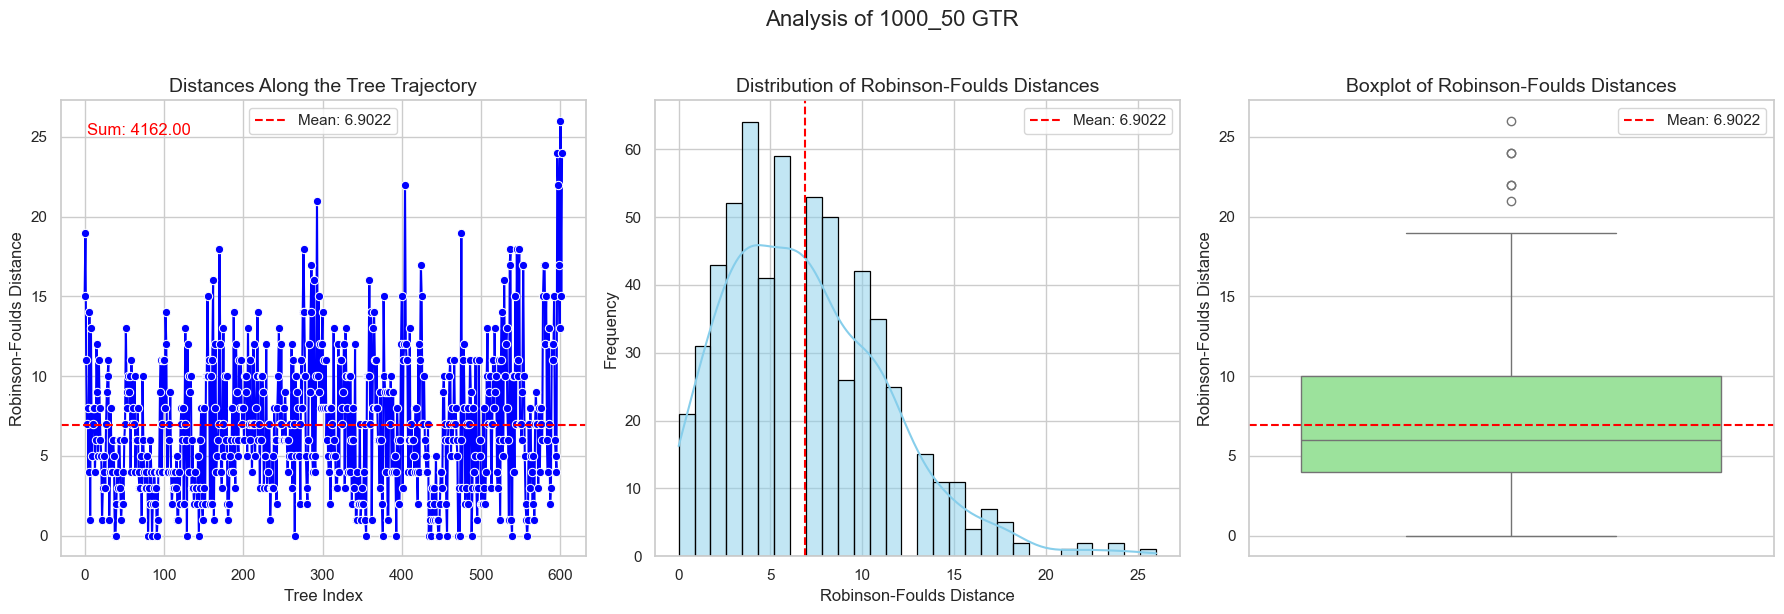

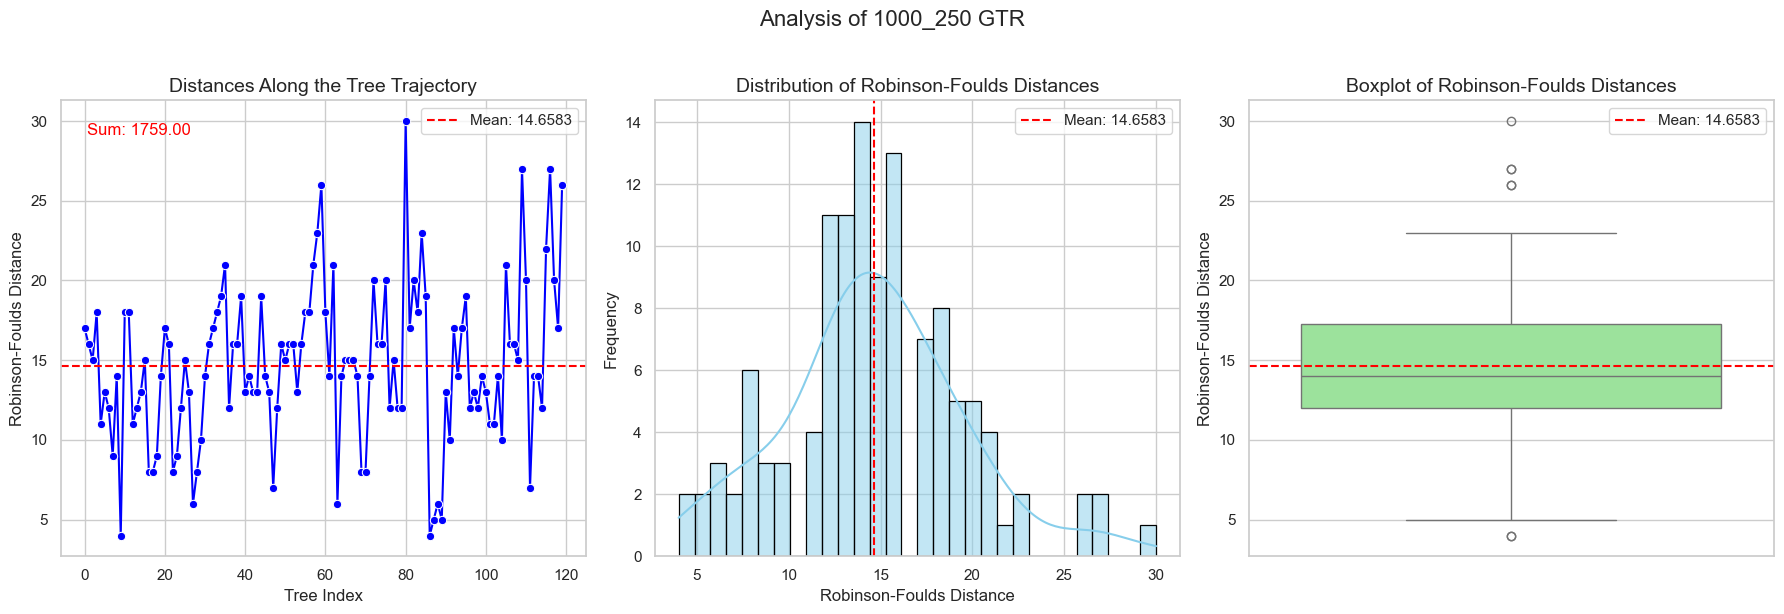

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from brancharchitect.distances import (
    calculate_along_trajectory,
    robinson_foulds_distance,
)
from brancharchitect.io import read_newick

# If you're in a Jupyter notebook, include this line to display plots inline
%matplotlib inline

# Define your experiment names
experiment_name1 = "all_trees
experiment_name2 = "Analysis of 1000_250 GTR"

# Paths to your Newick files
tree_file_path1 = Path(
    "./../data/trimmed_sequences_windoes_1000_50_GTR/trimmed_sequences_window_1000_50_GTR_best_trees.newick"
)
tree_file_path2 = Path(
    "./../data/trimmed_sequences_window_1000_250_GTR/best_trees.newick"
)

# Read tree lists from Newick files
tree_list1 = read_newick(tree_file_path1)
tree_list2 = read_newick(tree_file_path2)

# Calculate distances along the tree trajectories
distances1 = calculate_along_trajectory(tree_list1, robinson_foulds_distance)
distances2 = calculate_along_trajectory(tree_list2, robinson_foulds_distance)

# Calculate means (average distances)
mean_distance1 = sum(distances1) / len(distances1)
mean_distance2 = sum(distances2) / len(distances2)

# Print mean distances
print(f"Mean distance for {experiment_name1}: {mean_distance1:.4f}")
print(f"Mean distance for {experiment_name2}: {mean_distance2:.4f}")

def plot_robinson_foulds_distances(distances, experiment_name, mean_distance):
    """
    Plots the Robinson-Foulds distances calculated along the trajectory of trees.
    Generates multiple advanced plots for analysis within the Jupyter notebook.
    """
    # Convert distances to a pandas Series
    distances_series = pd.Series(distances)

    # Set up the plotting style
    sns.set_style("whitegrid")
    sns.set_palette("deep")

    # Create a 1x3 grid of plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Line Plot of Distances Over Time
    sns.lineplot(
        ax=axes[0],
        x=distances_series.index,
        y=distances_series.values,
        marker='o',
        color='blue'
    )
    axes[0].set_title("Distances Along the Tree Trajectory", fontsize=14)
    axes[0].set_xlabel("Tree Index", fontsize=12)
    axes[0].set_ylabel("Robinson-Foulds Distance", fontsize=12)
    # Add horizontal line for the mean distance
    axes[0].axhline(mean_distance, color='red', linestyle='--', label=f'Mean: {mean_distance:.4f}')
    axes[0].legend()
    # Annotate with sum of distances
    total_distance = sum(distances)
    axes[0].annotate(
        f"Sum: {total_distance:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        color='red',
        verticalalignment='top'
    )

    # 2. Histogram with KDE
    sns.histplot(
        ax=axes[1],
        data=distances_series,
        bins=30,
        kde=True,
        color='skyblue',
        edgecolor='black'
    )
    axes[1].set_title("Distribution of Robinson-Foulds Distances", fontsize=14)
    axes[1].set_xlabel("Robinson-Foulds Distance", fontsize=12)
    axes[1].set_ylabel("Frequency", fontsize=12)
    # Annotate with mean distance
    axes[1].axvline(mean_distance, color='red', linestyle='--', label=f'Mean: {mean_distance:.4f}')
    axes[1].legend()

    # 3. Boxplot of Distances
    sns.boxplot(ax=axes[2], y=distances_series, color='lightgreen')
    axes[2].set_title("Boxplot of Robinson-Foulds Distances", fontsize=14)
    axes[2].set_ylabel("Robinson-Foulds Distance", fontsize=12)
    # Add horizontal line for mean in boxplot
    axes[2].axhline(mean_distance, color='red', linestyle='--', label=f'Mean: {mean_distance:.4f}')
    axes[2].legend()

    # Adjust layout and display the figure
    plt.suptitle(f"{experiment_name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Generate and display the plots for the first dataset
plot_robinson_foulds_distances(
    distances=distances1,
    experiment_name=experiment_name1,
    mean_distance=mean_distance1
)

# Generate and display the plots for the second dataset
plot_robinson_foulds_distances(
    distances=distances2,
    experiment_name=experiment_name2,
    mean_distance=mean_distance2
)